# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
  
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>

## <center>Projeto Final</center>

**Nome**: Anne Mari Suenaga Sakai
**RA**: 822304

**Nome**: Felipe Jun Nishitani
**RA**: 822353


---
## Imports e configuração inicial

Carregamos os módulos necessários, incluindo os scripts do projeto.

In [163]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.preprocessamento import *
from scripts.analise_exploratoria import *
from scripts.experimentos import *
from scripts.analise_resultados import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Análise Exploratória 

Nesta seção realizamos a leitura inicial da base de dados e conduzimos uma análise exploratória para compreender o comportamento dos sinais fisiológicos, verificar sua qualidade e identificar padrões relevantes para a etapa de aprendizado de máquina.

A análise exploratória inclui:
- Compreensão do significado fisiológico de cada atributo
- Cálculo de medidas descritivas (média, desvio padrão, tendência, dispersão)
- Visualizações gráficas (histogramas, boxplots, correlações, distribuições por classe)
- Identificação de valores atípicos, padrões inconsistentes e redundâncias
- Avaliação das relações entre sensores (ACC × HR, HRV × EDA, etc.)


### Correlação entre Atributos

A base contém atributos derivados de sensores vestíveis, representando **estatísticas agregadas** (médias, desvios padrão, energia, entropia e tendências) calculadas a partir de sinais fisiológicos registrados para cada usuário.  
Essas medições resumem informações sobre movimento, atividade autonômica, temperatura corporal e comportamento cardiovascular.  


**1. Acelerômetro (ACC)**

O acelerômetro mede a intensidade e variação do movimento corporal. É fundamental para distinguir atividade física de stress emocional, pois stress pode ocorrer mesmo com o corpo parado.

 Atributos extraídos:
- acc_mag_mean – média da magnitude do vetor de aceleração  
- acc_mag_std – desvio padrão da magnitude (variação do movimento)  
- acc_energy – energia do sinal (indicador direto da intensidade do movimento)  
- acc_entropy – entropia do movimento (complexidade e irregularidade do padrão)

 Interpretação:
- Valores altos → movimento intenso → exercício.  
- Valores baixos → pouco movimento → possível stress quando combinado a sinais autonômicos.



**2. Variabilidade Cardíaca (HRV)**

A HRV é calculada a partir dos intervalos entre batimentos cardíacos (IBI). Ela reflete o equilíbrio entre o sistema nervoso simpático (ativação) e parassimpático (relaxamento), sendo uma das métricas mais usadas para identificar stress.

 Atributos extraídos:
- hrv_rmssd – sensível às oscilações rápidas controladas pelo parassimpático  
- hrv_sdnn – variabilidade global ao longo da sessão

  Interpretação:
- HRV alta → estado calmo / recuperação.  
- HRV baixa → ativação simpática → stress emocional ou fadiga física.


**3. Atividade Eletrodérmica (EDA)**
A EDA mede a condutância da pele, que aumenta quando há ativação do sistema nervoso simpático (suor emocional). É um dos sinais fisiológicos mais fortes para detectar stress.

 Atributos extraídos:
- eda_tonic_mean – nível basal sustentado  
- eda_phasic_mean – picos rápidos de ativação  
- eda_mean – valor médio total  
- eda_std – variação e reatividade do sinal

 Interpretação:
- Valores altos ou muito variáveis → grande ativação autonômica → stress.  
- Durante exercício, EDA também sobe, mas acompanhada de movimento (ACC alto).


**4. Temperatura da Pele (TEMP)**
A temperatura periférica reflete mudanças no fluxo sanguíneo. Ela tende a aumentar no exercício (aquecimento metabólico) e diminuir no stress (vasoconstrição).

 Atributos extraídos:
- temp_mean – temperatura médio  
- temp_std – flutuação  
- temp_slope – tendência ao longo do tempo (aumento ou queda)

 Interpretação:
- Slope positivo → aumento térmico → exercício.  
- Slope negativo → queda periférica → stress.


**5. Frequência Cardíaca (HR)**
A frequência cardíaca aumenta tanto em exercícios quanto em situações de stress, mas seu comportamento se diferencia quando observada junto com ACC e HRV.

 Atributos extraídos:
- hr_mean – média da frequência cardíaca  
- hr_std – variação do sinal

 Interpretação:
- HR alta + ACC alta → exercício.  
- HR alta + ACC baixa → stress emocional.


**6. Onda de Volume de Pulso (BVP)**
O sinal BVP mede variações no volume sanguíneo periférico via fotopletismografia. Embora seja usado para derivar HR e HRV, ele também reflete perfusão e circulação periférica.

 Atributo extraído:
- bvp_mean – média do volume de pulso

 Interpretação:
- Perfusão periférica menor → possível vasoconstrição → stress.  
- Durante exercício, tende a se manter estável devido à redistribuição do fluxo sanguíneo.


In [164]:
base_path = "dataset"
df = carregar_e_resumir(base_path)


--- Carregando dataset ---

Primeiras linhas do dataset:


,Id,classe,acc_energy,acc_entropy,acc_mag_mean,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,eda_tonic_mean,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
0,U_79201,STRESS,4068.866638,0.820908,63.758315,1.934911,0.020494,2.189811,-0.001937,0.514308,2.191749,98.881952,12.672493,0.045673,0.064240,34.275062,0.000268,0.530891
1,U_56491,ANAEROBIC,4208.309169,0.682113,64.493546,6.992256,0.021553,0.695010,-0.001748,0.666640,0.696758,88.239135,19.887299,0.120337,0.207697,28.352012,-0.000183,0.636924
2,U_94628,ANAEROBIC,4142.529156,0.599849,64.116317,5.623789,0.009702,4.049409,-0.001584,3.069452,4.050993,105.976423,19.883682,0.065383,0.105671,33.945142,0.000137,0.484733
3,U_97819,AEROBIC,4220.643865,0.540780,64.888648,3.179186,0.029392,5.359092,-0.001485,5.371593,5.360577,84.828580,11.066248,0.097257,0.114572,30.958938,0.000147,0.743493
4,U_96956,STRESS,4188.899763,0.666053,64.686163,2.144774,0.001560,0.670497,-0.001202,0.493036,0.671699,79.585647,6.230386,0.056268,0.073907,31.658291,-0.000074,0.358782



Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               75 non-null     object 
 1   classe           75 non-null     object 
 2   acc_energy       75 non-null     float64
 3   acc_entropy      75 non-null     float64
 4   acc_mag_mean     75 non-null     float64
 5   acc_mag_std      75 non-null     float64
 6   bvp_mean         75 non-null     float64
 7   eda_mean         75 non-null     float64
 8   eda_phasic_mean  75 non-null     float64
 9   eda_std          75 non-null     float64
 10  eda_tonic_mean   75 non-null     float64
 11  hr_mean          75 non-null     float64
 12  hr_std           75 non-null     float64
 13  hrv_rmssd        73 non-null     float64
 14  hrv_sdnn         73 non-null     float64
 15  temp_mean        74 non-null     float64
 16  temp_slope       74 non-null     float64
 1

,Id,classe,acc_energy,acc_entropy,acc_mag_mean,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,eda_tonic_mean,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
count,75,75,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,73.000000,73.000000,74.000000,74.000000,74.000000
unique,75,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,U_11894,ANAEROBIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,4300.559844,0.838452,64.888560,3.955418,0.003332,6.680819,-0.002192,3.823965,6.683011,93.882473,16.821741,0.063188,0.100189,32.369715,0.000010,0.631250
std,NaN,NaN,1675.109339,0.363718,8.257245,2.685613,0.011656,8.233190,0.001327,4.142668,8.233274,16.155851,9.073584,0.028234,0.040062,1.796072,0.000294,0.418633
min,NaN,NaN,3768.045932,0.540780,61.359069,1.076043,-0.032294,0.238126,-0.010193,0.056461,0.239361,62.228672,4.655147,0.027499,0.036318,25.295883,-0.000937,0.035736
25%,NaN,NaN,4045.069770,0.638203,63.529587,2.117531,-0.002810,1.361458,-0.002768,0.918854,1.364135,81.933728,9.794185,0.043321,0.069818,31.496474,-0.000141,0.317925
50%,NaN,NaN,4143.999590,0.710770,64.276497,3.431269,0.003114,3.690940,-0.001873,2.595732,3.692786,92.051647,16.005342,0.053799,0.094895,32.454401,0.000059,0.552936
75%,NaN,NaN,4206.539459,0.898641,64.712951,5.025788,0.009903,8.649052,-0.001390,4.991839,8.651783,105.350650,21.402240,0.073565,0.123224,33.580486,0.000167,0.868366


### Medidas Descritivas

Antes de qualquer pré-processamento, avaliamos a distribuição das classes e a presença de valores ausentes.
Essas informações ajudam a identificar possíveis problemas no dataset e orientam as primeiras decisões de limpeza:

- A distribuição das classes permite verificar se há desbalanceamento, o que pode influenciar o desempenho dos modelos e a escolha de métricas.
- A inspeção de valores ausentes indica se será necessário realizar algum tratamento de faltantes ou se o dataset já está consistente o suficiente para prosseguir.


--- Medidas Descritivas ---

Distribuição das classes:


ANAEROBIC    28
STRESS       25
AEROBIC      22
Name: classe, dtype: int64

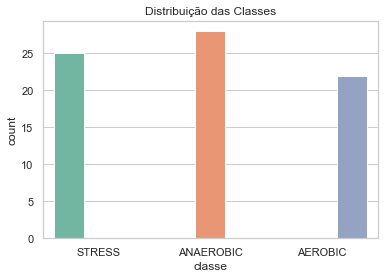


Valores ausentes por coluna:


Id                 0
classe             0
acc_energy         0
acc_entropy        0
acc_mag_mean       0
acc_mag_std        0
bvp_mean           0
eda_mean           0
eda_phasic_mean    0
eda_std            0
eda_tonic_mean     0
hr_mean            0
hr_std             0
hrv_rmssd          2
hrv_sdnn           2
temp_mean          1
temp_slope         1
temp_std           1
dtype: int64

In [165]:
medidas_descritivas(df)

**Análise das medidas descritivas:**

A distribuição das classes está relativamente equilibrada, com ANAEROBIC (28), STRESS (25) e AEROBIC (22) amostras. Esse leve desequilíbrio não é significativo a ponto de exigir técnicas de balanceamento. 

Além disso, a verificação de valores ausentes mostra que a maioria dos atributos está completa, apresentando apenas poucos faltantes em HRV (RMSSD, SDNN) e algumas lacunas em temperatura (mean, slope, std). Esses valores devem ser tratados para evitar que o modelo aprenda padrões distorcidos ou descarte linhas inteiras. 

### Correlação entre Atributos

A matriz de correlação é utilizada para identificar relações lineares entre os atributos fisiológicos, permitindo detectar redundâncias, atributos altamente informativos e potenciais combinações úteis. Com base nessa análise, escolhemos quais variáveis merecem inspeção visual mais detalhada na etapa seguinte, por meio de boxplots e histogramas.


--- Matriz de Correlação ---


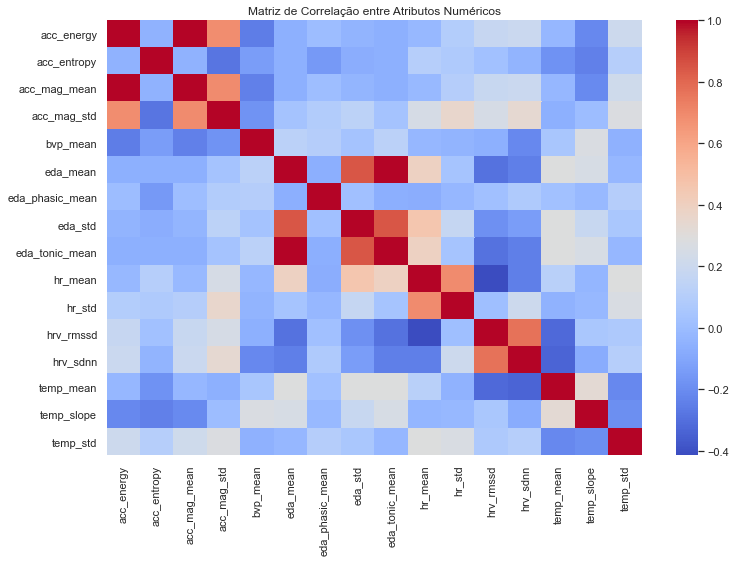


🔗 Maiores correlações:


eda_mean      eda_tonic_mean    1.000000
acc_energy    acc_mag_mean      0.999056
eda_mean      eda_std           0.849207
eda_std       eda_tonic_mean    0.849195
hrv_rmssd     hrv_sdnn          0.769044
hr_mean       hr_std            0.695529
acc_mag_mean  acc_mag_std       0.692277
acc_energy    acc_mag_std       0.690494
eda_std       hr_mean           0.463673
hr_mean       hrv_rmssd        -0.414861
dtype: float64

In [166]:
correlacao_atributos(df)

**Análise das correlações:**

A matriz de correlação revelou padrões importantes sobre a relação entre os sinais fisiológicos, fornecendo evidências diretas para decisões de pré-processamento que serão aplicadas posteriormente. 

Os pares com maior correlação observada foram acc_energy e acc_mag_mean (= 1.00) e eda_mean e eda_tonic_mean (0.999). Esses atributos variam de forma praticamente idêntica ao longo das amostras, indicando que carregam essencialmente a mesma informação fisiológica. Manter ambos poderia levar à redundância e multicolinearidade, sem benefício real para o modelo. Assim, a análise aponta para a futura remoção desses atributos. Escolhemos retirar acc_mag_mean e eda_tonic_mean, mantendo acc_energy e eda_mean, que apresentam variação mais significativa e informativa.

Além desses pares redundantes, a matriz também evidenciou grupos fortemente relacionados, como hr_mean com hr_std e eda_mean com eda_std. Apesar da correlação elevada, esses atributos capturam dimensões complementares dos sinais (nível versus variabilidade), de modo que não são candidatos imediatos à remoção. Ainda assim, essas dependências estruturadas entre os sinais indicam que relações mais complexas podem ser exploradas, motivando a criação posterior de features de interação.

Assim, a análise de correlação fornece os indícios necessários para três etapas de pré-processamento que serão aplicadas posteriormente:
- Remoção de atributos redundantes, conforme identificado nos pares com correlação perfeita;
- Criação de features de interação, para capturar relações fisiológicas relevantes entre sensores;
- Transformações e padronizações adicionais, como log-transform para assimetrias e Z-score para tratamento de outliers (já motivadas pelos boxplots e histogramas).

### Boxplots e Histogramas

Nesta etapa da análise exploratória, utilizamos boxplots e histogramas para investigar a distribuição
dos atributos numéricos e verificar possíveis anomalias nos sinais fisiológicos.

Os **boxplots** permitem visualizar valores extremos, amplitude interquartil e diferenças entre as
classes, sendo úteis para identificar padrões relacionados a outliers e dispersão anormal dos dados.

Já os **histogramas** mostram a forma da distribuição (simétrica, assimétrica, longa, truncada ou
multimodal) revelando características importantes de sinais fisiológicos como EDA, HRV, ACC e HR,
que normalmente não seguem distribuições gaussianas.

Essas visualizações ajudam a:
- Identificar assimetrias fortes e caudas longas nos dados  
- Observar diferenças claras entre STRESS, AEROBIC e ANAEROBIC  
- Detectar atributos que precisam de transformações (como log)  
- Avaliar se técnicas padrão de detecção de outliers (como IQR) são adequadas ou não  

Para evitar gerar visualizações redundantes, esta função utiliza uma seleção inteligente dos atributos mais relevantes com base em variância, correlação e importância estatística frente à classe. Assim, exibimos apenas os sinais mais informativos em boxplots e histogramas organizados em grade.


--- Boxplots e Histogramas (seleção inteligente) ---

🧠 Atributos selecionados para visualização: ['acc_energy', 'hr_mean', 'hr_std', 'acc_mag_mean', 'eda_tonic_mean', 'eda_mean']


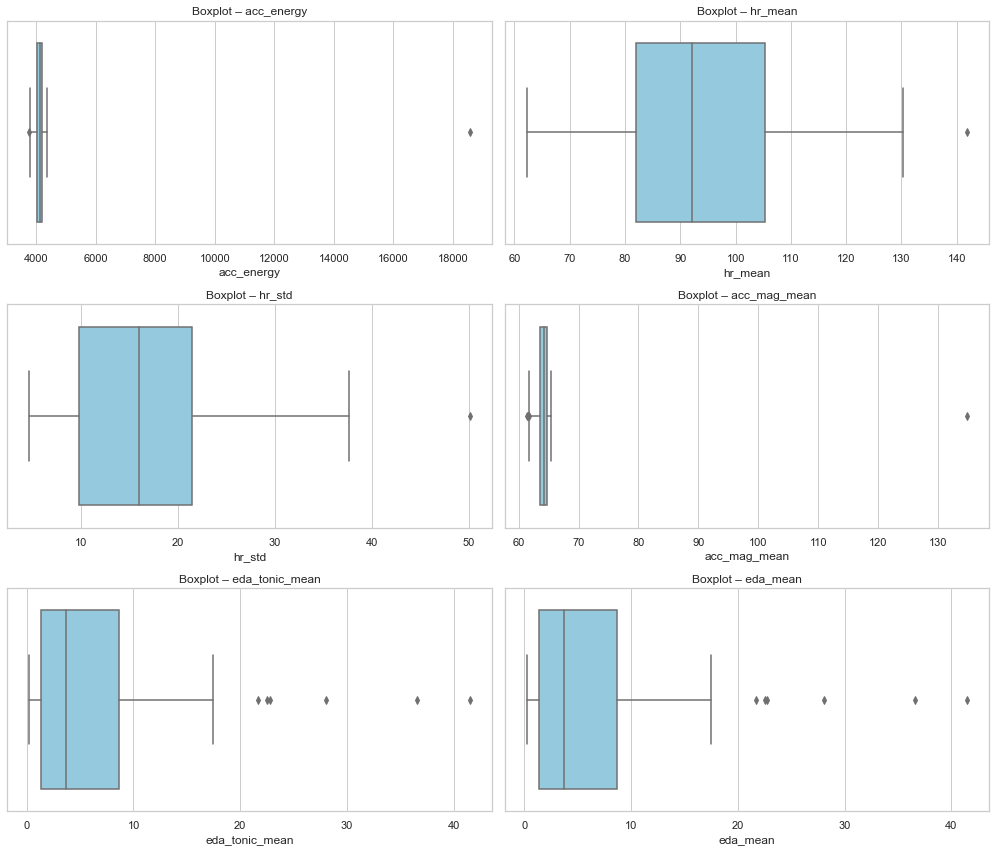

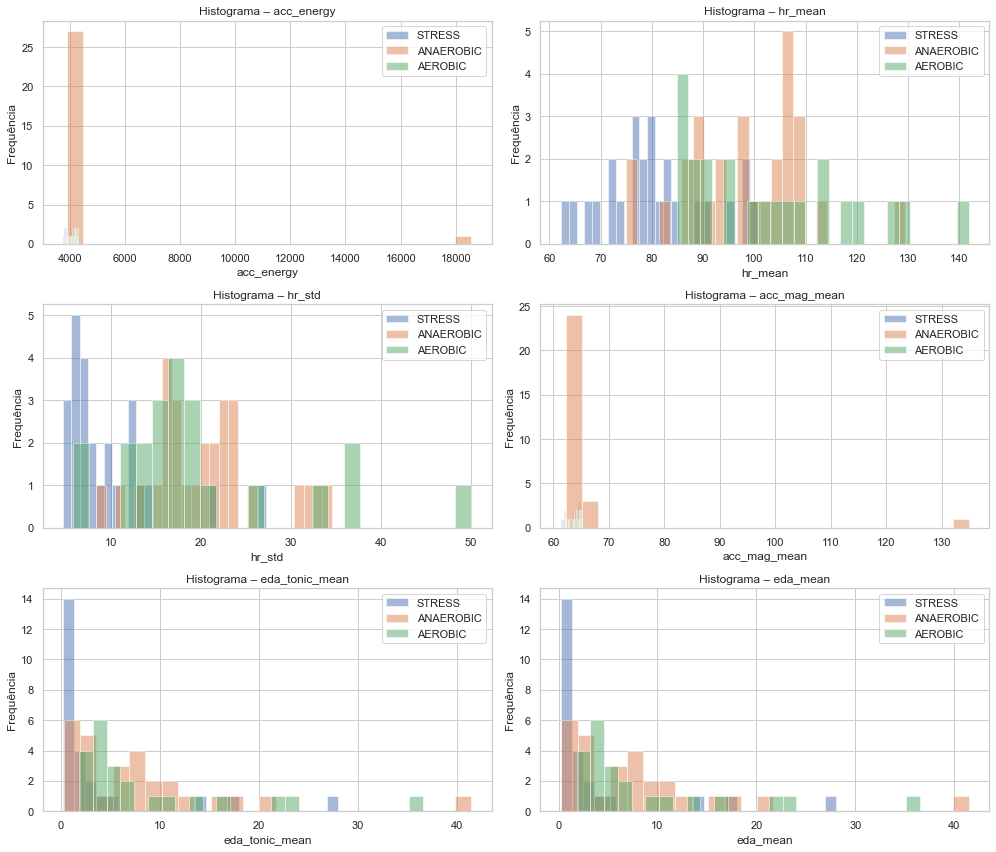

In [167]:
boxplots_e_histogramas(df)

**Análise dos Boxplots e Histogramas:**

A análise dos boxplots e histogramas revela que diversos atributos apresentam forte assimetria e valores extremos bem definidos, especialmente nos sinais de EDA, BVP e ACC. Esses atributos exibem caudas longas à direita e picos elevados que, embora representem respostas fisiológicas reais, distorcem a distribuição e ampliam a variância. Além disso, os dados se encontram em escalas muito distintas, o que reforça a necessidade de padronização antes do treinamento dos modelos.

Assim, as análises evidenciam a necessidade de: 
- Aplicar transformação logarítmica aos atributos mais enviesados, pois:
    - reduzir a assimetria, 
    - estabilizar a variância,
    - suavizar a influência de picos
- Tratar outliers de forma controlada com Z-score, pois:
    - ajusta melhor ao comportamento naturalmente assimétrico dos sinais fisiológicos
- Evitar IQR por não ser adequado ao perfil assimétrico dos dados fisiológicos.

### Pairplot Amostrado

O Pairplot (ou matriz de dispersão) é uma ferramenta visual essencial na Análise Exploratória de Dados (AED). Ele apresenta as relações bivariadas entre os atributos selecionados, usando gráficos de dispersão nas células off-diagonal e a distribuição de frequência (KDE) na diagonal principal. Seu objetivo é crucial para identificar:
- Separabilidade visual das classes
- Presença de correlações não-lineares
- Necessidade de transformações para criar fronteiras de decisão mais nítidas


--- Pairplot Amostrado (focado em interações fisiológicas) ---
Gerando pairplot com 75 amostras e 7 atributos...


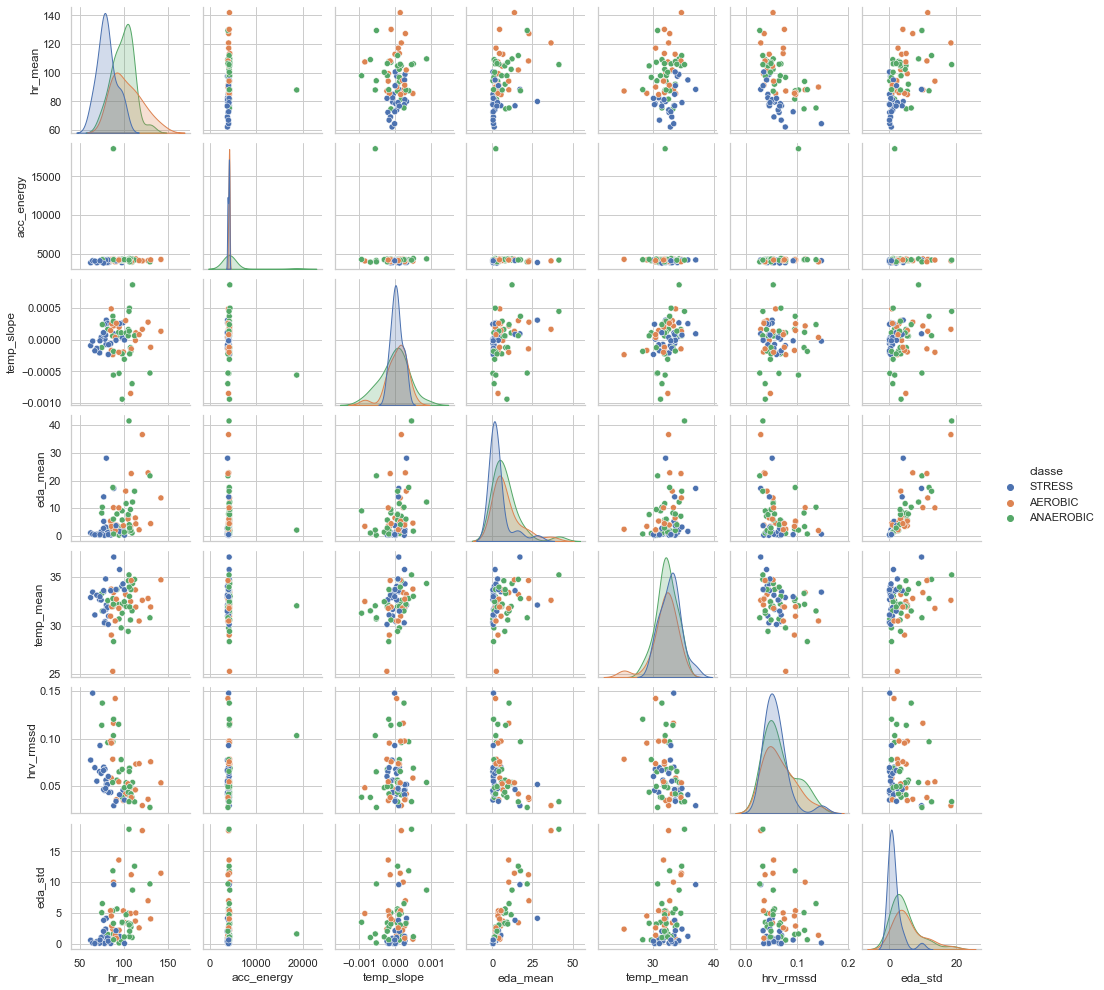

In [168]:
pairplot_amostrado(df)

**Análise dos Pairplots:**


Analisando os Pairplot é possível confirmar que a separação entre as classes Stress, Aerobic e Anaerobic é não-linear e complexa utilizando os atributos brutos. Essa característica é o principal indício da necessidade de pré-processamento focado na criação de features derivadas.

1. Evidência de Fronteiras Não-Lineares (Motiva a Criação de Features de Interação):
Em diversos gráficos de dispersão (como hr_mean vs. acc_energy ou hrv_rmssd vs. eda_std), as classes se sobrepõem de forma que não seria possível separá-las com uma linha reta.
    - O Stress (azul) frequentemente se agrupa em regiões onde um atributo está alto e o outro está baixo (ex: hr_mean alto e acc_energy baixo), caracterizando uma relação de razão ou produto.
    - O Exercício (laranja e verde) tende a apresentar uma relação mais balanceada ou crescente entre os pares.
    
    Essa falta de separabilidade linear demonstra que o poder preditivo não está em cada sensor isoladamente, mas sim na combinação fisiológica deles. Portanto, a análise motiva diretamente a criação de features de interação para transformar essas fronteiras curvas ou angulares em relações mais lineares em um novo espaço de atributos.
    
2. Distribuições Assimétricas e Sobreposição (Motiva Escalonamento e Transformações):
Os gráficos KDE na diagonal principal mostram que muitos atributos (como acc_energy e eda_mean) possuem distribuições assimétricas ou fortemente concentradas. Além disso, a intensa superposição das distribuições de classe para a maioria dos atributos individuais (ex: $\mathbf{temp\_slope}$) reforça a dificuldade em usar esses atributos sozinhos.
    - Necessidade de Escalonamento (Padronização Z-score): Atributos com alta dispersão (acc-energy) não devem dominar o modelo. O escalonamento garante que todos os atributos contribuam igualmente para a função de custo do modelo.
    - Necessidade de Transformações (Log-transform): A assimetria observada em algumas distribuições (como eda_mean) sugere que transformações (como a logarítmica) podem ser necessárias para aproximar a distribuição de uma Gaussiana, melhorando a performance de modelos paramétricos.
    

A análise visual do pairplot complementa a matriz de correlação, reforçando a necessidade de:
- Criação de Features de Interação: Para capturar as relações fisiológicas não-lineares que separam efetivamente os estados de Stress e Exercício.
- Transformações e Escalonamento: Para tratar assimetrias, outliers e garantir que todos os atributos transformados contribuam de forma justa para o treinamento do modelo.

### Séries Temporais

Foram plotadas as séries agregadas de cada sensor (HR, HRV, EDA, ACC e temperatura) ao longo das amostras. Esses gráficos são essenciais, pois permitem identificar a dinâmica temporal e padrões globais entre os participantes, como variações amplas na atividade eletrodérmica e na frequência cardíaca, frequentemente associadas a estados de estresse, bem como valores mais elevados de aceleração média em casos de exercícios aeróbicos e anaeróbicos. A visualização no tempo é o ponto de partida para a criação de features que capturam a mudança e a variabilidade dos sinais.


--- Séries Temporais (Subplots) ---


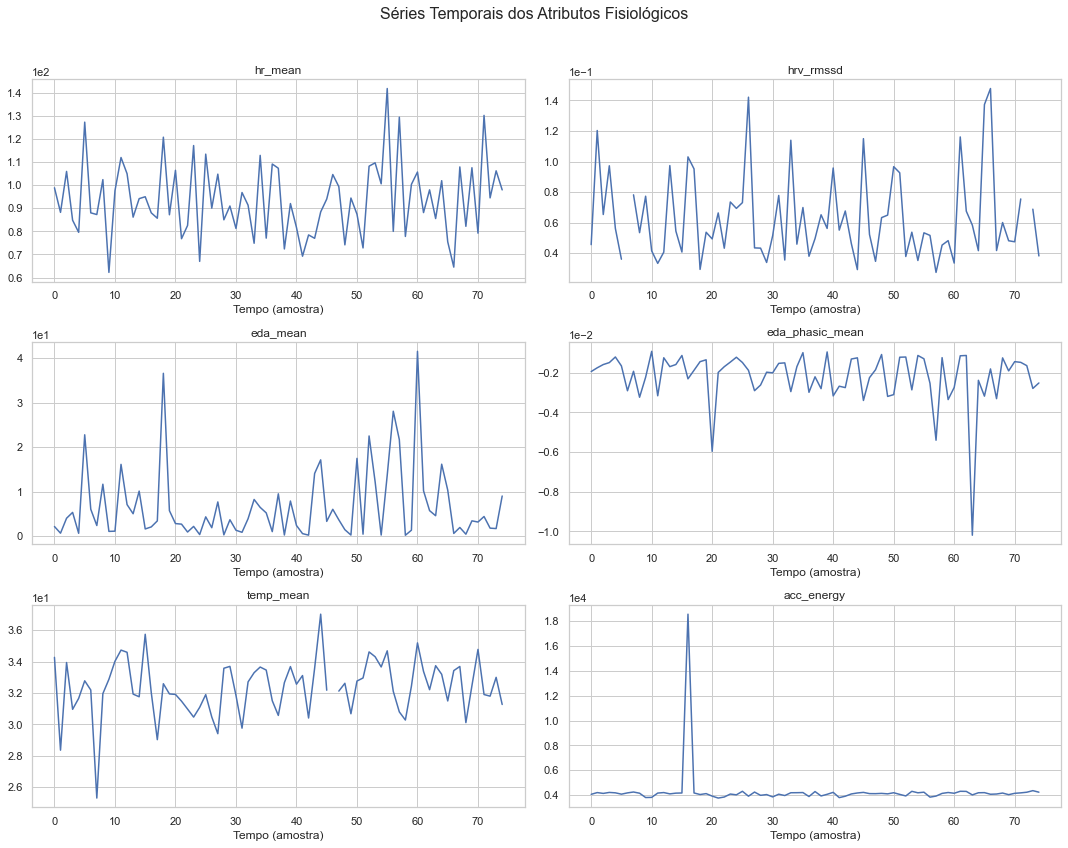

In [169]:
plot_series_temporais(df, [
    "hr_mean",
    "hrv_rmssd",
    "eda_mean",
    "eda_phasic_mean",
    "temp_mean",
    "acc_energy"
])


**Análise das Séries Temporais:**

1. Evidência de Mudança Lenta e Tendencial (Motiva a Criação da Feature temp_slope):
    
O sinal de temperatura (temp_mean) se destaca por apresentar variações lentas, sem os picos agudos vistos em outros sensores.
    - O slope (taxa de mudança) é mais informativo do que o valor médio da temperatura em si.
    - Motivação: A criação da feature temp_slope é necessária para capturar a termorregulação e diferenciar a resposta metabólica do Exercício da vasoconstrição periférica do Stress.

2. Picos Extremos e Artefatos (Motiva a Limitação de Outliers):

Em diversos sinais, especialmente acc_energy e eda_mean, a série temporal exibe picos súbitos e isolados que estão muito distantes da média dos dados.
    - Esses outliers extremos podem distorcer o cálculo de estatísticas e desviar o processo de otimização de modelos.
    - Motivação: A detecção e limitação (clamping) desses valores, utilizando métodos robustos como o Z-score ou o Intervalo Interquartil (IQR), são essenciais para garantir que as features derivadas e o modelo não sejam enviesados por dados anômalos.

3. Alta Volatilidade e Assimetria de Resposta (Motiva Transformações Logarítmicas):

Sinais de resposta autonômica como hrv_rmssd e eda_mean apresentam alta volatilidade e assimetria (picos súbitos de ativação).
    - Essa assimetria inerente é problemática para modelos que pressupõem distribuições mais normais.
    - Motivação: A aplicação de uma transformação logarítmica (*Log-transform*) em atributos como hrv_rmssd e eda_mean é necessária para estabilizar a variância e criar uma distribuição mais simétrica, melhorando o desempenho de modelos.

A análise das séries temporais fornece os indícios cruciais que complementam o pairplot e a matriz de correlação, reforçando a necessidade de:
- Criação de Features Temporais: Uso da feature temp_slope para capturar a dinâmica de mudança da termorregulação.
- Limitação de Outliers: Aplicação de limites de Z-score para mitigar o impacto de picos e artefatos.
- Transformações de Distribuição: Uso de Log-transform em atributos assimétricos para estabilizar a variância.

### Scatter Duplo
Também foram analisadas relações entre pares de sensores, como HR × EDA, ACC × HR e HRV × EDA. Os gráficos de dispersão revelam separações naturais entre os estados fisiológicos: indivíduos em condição de estresse tendem a apresentar EDA elevada combinada com RMSSD reduzido, enquanto atividades aeróbicas e anaeróbicas apresentam maior magnitude de aceleração e frequência cardíaca, porém com diferentes assinaturas eletrodérmicas.

Os gráficos de dispersão mostraram relações importantes entre sensores. O par HR × EDA evidenciou um agrupamento de indivíduos com ambos os valores elevados, sugerindo estados de alto arousal fisiológico, típicos de estresse. A relação inversa entre HRV e EDA phasic indica diminuição da atividade parassimpática em situações de estresse. Já ACC × HR ajudou a diferenciar claramente atividades físicas de episódios de estresse, já que esforço físico tende a aumentar simultaneamente aceleração e frequência cardíaca.


--- Scatter Plots Duplos (Subplots) ---


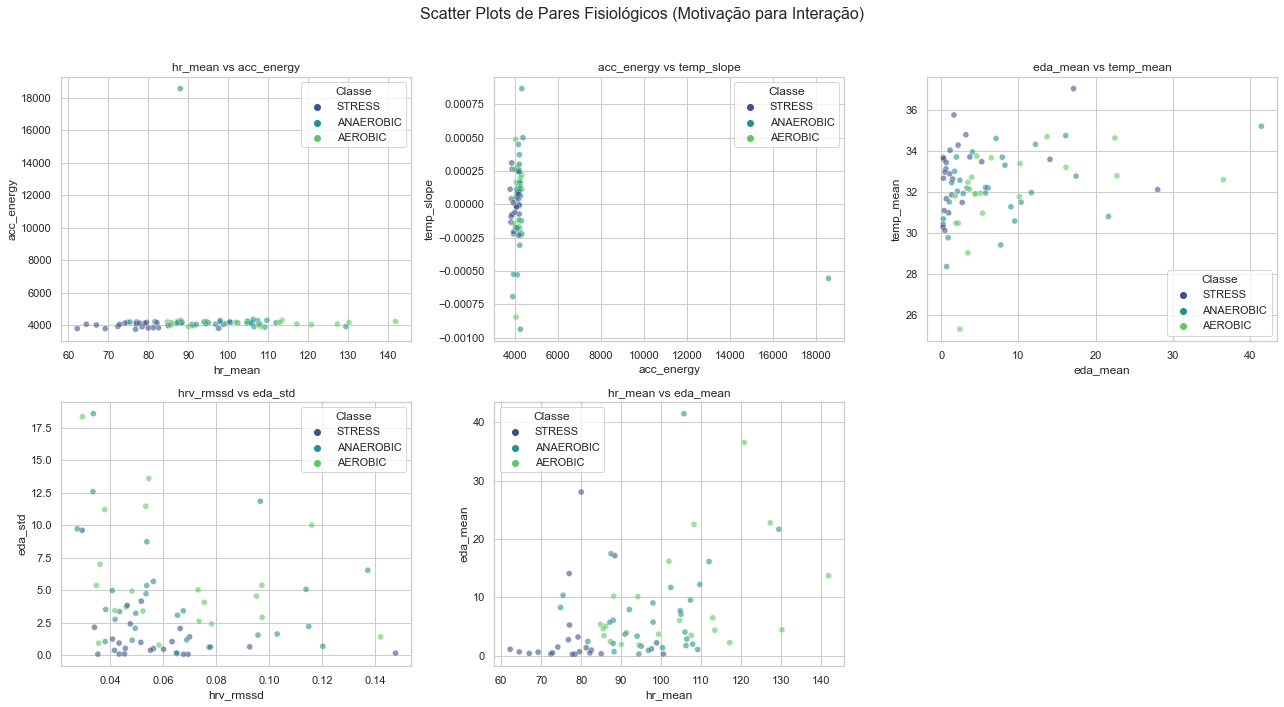

In [170]:
pares_interacao = [
    ("hr_mean", "acc_energy"),
    ("acc_energy", "temp_slope"),
    ("eda_mean", "temp_mean"),
    ("hrv_rmssd", "eda_std"),
    ("hr_mean", "eda_mean")
]
scatter_duplo(df, pares_interacao)

**Análise dos Scatter Plots Duplos:**

Analisando os Scatter Plots Duplos é possível confirmar que a separação entre as classes Stress, Aerobic e Anaerobic é não-linear e complexa utilizando os atributos brutos. Essa característica é o principal indício da necessidade de pré-processamento focado na criação de features derivadas.

1. Relação Não-Linear de Razão (Motiva a Criação da Feature HR/ACC):
O gráfico hr_mean vs. acc_energy mostra a classe STRESS concentrada na região superior esquerda (alta frequência cardíaca e baixo movimento).
    - Essa distribuição angular demonstra que o poder preditivo não está nos valores absolutos, mas na razão entre eles.
    - Motivação: Essa relação complexa exige a criação da feature de razão inter_hr_acc_ratio (HR / ACC) para linearizar a fronteira de separação.

2. Dispersão de Amplitude e Outliers (Motiva Escalonamento e Clamping):
Gráficos como acc_energy vs. temp_slope e hrv_rmssd vs. eda_std mostram diferenças drásticas nas escalas (ex: hrv_rmssd vs. eda_std) e a presença de outliers extremos (ex: acc_energy).
    - A grande diferença nas amplitudes dos eixos pode fazer com que atributos com maior escala dominem o modelo.
    - Motivação: É essencial aplicar o Escalonamento (Padronização Z-score) para equalizar a contribuição de todos os atributos. Além disso, a presença de outliers reforça a necessidade de limitação (clamping).

3. Agrupamento em Zonas Fisiológicas (Motiva Features de Produto):
O gráfico hrv_rmssd vs. eda_std mostra que a classe STRESS tende a se agrupar em zonas de baixa HRV e alta oscilação de EDA, uma assinatura de ativação simpática.
    - Motivação: As *features* de produto (como inter_hrv_eda e inter_eda_temp_mult) são criadas para amplificar a separação dessas zonas fisiológicas, onde a combinação dos valores (multiplicação) cria uma dimensão mais discriminativa do que os eixos isolados.

A análise visual dos scatter plots duplos é a justificativa final para:
- Criação de Features de Interação: Para transformar as relações angulares e não-lineares em novas dimensões lineares.
- Transformações e Escalonamento: Para tratar assimetrias, outliers e garantir que todos os atributos contribuam de forma justa para o treinamento do modelo.

---
## Pré-processamento

Com base na análise exploratória, aplicamos técnicas de pré-processamento para melhorar a qualidade e a utilidade dos dados antes do treinamento dos modelos:
- Tratamento de valores faltantes
- Remoção de atributos redundantes
- Normalização e padronização de variáveis numéricas
- Transformações logarítmicas para estabilização de variância
- Limitação de outliers
- Engenharia de atributos (features derivadas)

### 1. Tratamento de Valores Ausentes (`tratar_valores_ausentes`)

* **O que faz:** Preenche os valores ausentes (`NaN` ou `?`) no *DataFrame*.
* **Método:** Utiliza a **mediana** para atributos numéricos (padrão) e a **moda** para atributos categóricos.
* **Justificativa:** A mediana é a estratégia mais **robusta** ao lidar com dados enviesados ou com a presença de *outliers* (como os observados em $\mathbf{acc\_energy}$ e $\mathbf{eda\_mean}$), garantindo que os dados possam ser usados nos passos subsequentes.

In [171]:
df_limpo = tratar_valores_ausentes(df)

df_limpo.head()

,Id,classe,acc_energy,acc_entropy,acc_mag_mean,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,eda_tonic_mean,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
0,U_79201,STRESS,4068.866638,0.820908,63.758315,1.934911,0.020494,2.189811,-0.001937,0.514308,2.191749,98.881952,12.672493,0.045673,0.064240,34.275062,0.000268,0.530891
1,U_56491,ANAEROBIC,4208.309169,0.682113,64.493546,6.992256,0.021553,0.695010,-0.001748,0.666640,0.696758,88.239135,19.887299,0.120337,0.207697,28.352012,-0.000183,0.636924
2,U_94628,ANAEROBIC,4142.529156,0.599849,64.116317,5.623789,0.009702,4.049409,-0.001584,3.069452,4.050993,105.976423,19.883682,0.065383,0.105671,33.945142,0.000137,0.484733
3,U_97819,AEROBIC,4220.643865,0.540780,64.888648,3.179186,0.029392,5.359092,-0.001485,5.371593,5.360577,84.828580,11.066248,0.097257,0.114572,30.958938,0.000147,0.743493
4,U_96956,STRESS,4188.899763,0.666053,64.686163,2.144774,0.001560,0.670497,-0.001202,0.493036,0.671699,79.585647,6.230386,0.056268,0.073907,31.658291,-0.000074,0.358782


### 2. Remoção de Atributos Redundantes (`remover_atributos_redundantes`)

* **O que faz:** Remove colunas que carregam informações duplicadas.
* **Atributos Removidos:** `eda_tonic_mean` e `acc_mag_mean`.
* **Justificativa:** A **matriz de correlação** confirmou que esses atributos são **redundantes** (correlação $\approx 1.0$) com `eda_mean` e `acc_energy`. Sua remoção é necessária para evitar **multicolinearidade** no modelo.

In [172]:
df_limpo = remover_atributos_redundantes(df_limpo)

df_limpo.head()

--- Atributos removidos: ['eda_tonic_mean', 'acc_mag_mean'] ---


,Id,classe,acc_energy,acc_entropy,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
0,U_79201,STRESS,4068.866638,0.820908,1.934911,0.020494,2.189811,-0.001937,0.514308,98.881952,12.672493,0.045673,0.064240,34.275062,0.000268,0.530891
1,U_56491,ANAEROBIC,4208.309169,0.682113,6.992256,0.021553,0.695010,-0.001748,0.666640,88.239135,19.887299,0.120337,0.207697,28.352012,-0.000183,0.636924
2,U_94628,ANAEROBIC,4142.529156,0.599849,5.623789,0.009702,4.049409,-0.001584,3.069452,105.976423,19.883682,0.065383,0.105671,33.945142,0.000137,0.484733
3,U_97819,AEROBIC,4220.643865,0.540780,3.179186,0.029392,5.359092,-0.001485,5.371593,84.828580,11.066248,0.097257,0.114572,30.958938,0.000147,0.743493
4,U_96956,STRESS,4188.899763,0.666053,2.144774,0.001560,0.670497,-0.001202,0.493036,79.585647,6.230386,0.056268,0.073907,31.658291,-0.000074,0.358782


### 3. Transformação Logarítmica (`aplicar_transformacao_log`)

* **O que faz:** Aplica a transformação $\ln(x+1)$ (`np.log1p`) em atributos com distribuição **altamente assimétrica** (enviesada).
* **Atributos Alvo:** `acc_energy`, `acc_mag_std`, `acc_entropy`, `eda_mean`, `eda_phasic_mean`.
* **Justificativa:** A **análise de séries temporais** e o *Pairplot* mostraram assimetria nesses sinais. A transformação ajuda a **estabilizar a variância** e a aproximar a distribuição da curva normal, permitindo o correto funcionamento do Z-score e melhorando modelos paramétricos.

In [173]:
df_limpo = aplicar_transformacao_log(df_limpo)

df_limpo.head()

--- Aplicando Log1p em: ['acc_energy', 'acc_mag_std', 'acc_entropy', 'eda_mean', 'eda_phasic_mean'] ---


,Id,classe,acc_energy,acc_entropy,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
0,U_79201,STRESS,8.311366,0.599335,1.076677,0.020494,1.159962,-0.001939,0.514308,98.881952,12.672493,0.045673,0.064240,34.275062,0.000268,0.530891
1,U_56491,ANAEROBIC,8.345054,0.520051,2.078473,0.021553,0.527689,-0.001749,0.666640,88.239135,19.887299,0.120337,0.207697,28.352012,-0.000183,0.636924
2,U_94628,ANAEROBIC,8.329303,0.469909,1.890668,0.009702,1.619271,-0.001585,3.069452,105.976423,19.883682,0.065383,0.105671,33.945142,0.000137,0.484733
3,U_97819,AEROBIC,8.347980,0.432289,1.430117,0.029392,1.849886,-0.001486,5.371593,84.828580,11.066248,0.097257,0.114572,30.958938,0.000147,0.743493
4,U_96956,STRESS,8.340432,0.510457,1.145742,0.001560,0.513121,-0.001202,0.493036,79.585647,6.230386,0.056268,0.073907,31.658291,-0.000074,0.358782


### 4. Limitação de Outliers Z-score (`limitar_outliers_zscore`)

* **O que faz:** **Limita** (*capping*) valores extremos (outliers) em vez de removê-los.
* **Método:** Valores acima de $\pm 3$ desvios padrão ($\pm 3 \sigma$) são substituídos pelo limite (média $\pm 3 \sigma$).
* **Justificativa:** A **análise das séries temporais** mostrou picos extremos (ex: $\mathbf{acc\_energy}$). O *capping* é a abordagem mais segura para **sinais temporais fisiológicos**, pois corrige o valor sem quebrar a sequência da amostra ou perder observações.

In [174]:
df_limpo = limitar_outliers_zscore(df_limpo, zmax=3.0)

df_limpo.head()

,Id,classe,acc_energy,acc_entropy,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
0,U_79201,STRESS,8.311366,0.599335,1.076677,0.020494,1.159962,-0.001939,0.514308,98.881952,12.672493,0.045673,0.064240,34.275062,0.000268,0.530891
1,U_56491,ANAEROBIC,8.345054,0.520051,2.078473,0.021553,0.527689,-0.001749,0.666640,88.239135,19.887299,0.120337,0.207697,28.352012,-0.000183,0.636924
2,U_94628,ANAEROBIC,8.329303,0.469909,1.890668,0.009702,1.619271,-0.001585,3.069452,105.976423,19.883682,0.065383,0.105671,33.945142,0.000137,0.484733
3,U_97819,AEROBIC,8.347980,0.432289,1.430117,0.029392,1.849886,-0.001486,5.371593,84.828580,11.066248,0.097257,0.114572,30.958938,0.000147,0.743493
4,U_96956,STRESS,8.340432,0.510457,1.145742,0.001560,0.513121,-0.001202,0.493036,79.585647,6.230386,0.056268,0.073907,31.658291,-0.000074,0.358782


### 5. Criação de Features de Interação (`criar_features_interacao`)

Esta etapa cria novos atributos combinando sensores, transformando as **relações não-lineares** observadas no *Pairplot* em relações mais lineares e preditivas. A criação dessas *features* é essencial para que modelos lineares e árvores de decisão possam capturar a complexa assinatura fisiológica que diferencia **Stress** de **Exercício**.

* **1. `inter_hr_acc_ratio`** ($\mathbf{HR} / (\mathbf{ACC} + 1)$)
    * **Significado Fisiológico:** Este é o **Índice de Stress Físico**. Ele relaciona o **esforço cardíaco** ($\mathbf{HR}$) ao nível de **atividade física** ($\mathbf{ACC}$).
    * **Interpretação e Utilidade:**
        * Um **valor alto** nesta *feature* indica **Stress** ou ansiedade, pois o indivíduo apresenta frequência cardíaca elevada sem o aumento proporcional no movimento corporal.
        * Um **valor baixo** ou moderado indica **Exercício**, onde $\mathbf{HR}$ e $\mathbf{ACC}$ aumentam juntos, mantendo a razão estável.
        * O uso da razão lineariza a separação angular observada no *scatter plot* $\mathbf{HR}$ vs. $\mathbf{ACC}$.

* **2. `inter_acc_temp`** ($\mathbf{ACC} \times \mathbf{Temp\_Slope}$)
    * **Significado Fisiológico:** Representa a **interação entre movimento e termorregulação**. Avalia como o esforço físico afeta a **taxa de mudança** (inclinação) da temperatura periférica.
    * **Interpretação e Utilidade:**
        * Ajuda a diferenciar o **Exercício** (muito movimento $\times$ aumento gradual de temperatura, resultando em um valor positivo) do **Stress** (pouco movimento $\times$ possível queda de temperatura periférica, podendo resultar em um valor negativo ou próximo de zero).
        * Captura a dinâmica temporal que o valor absoluto da temperatura ($\mathbf{Temp\_mean}$) não consegue.

* **3. `inter_eda_temp_mult`** ($\mathbf{EDA\_mean} \times \mathbf{Temp\_mean}$)
    * **Significado Fisiológico:** Representa a **Ativação Autonômica Combinada**. Relaciona a sudorese (atividade simpática, $\mathbf{EDA}$) com a temperatura corporal.
    * **Interpretação e Utilidade:**
        * Esta *feature* amplifica a assinatura típica de **Stress**, onde picos de $\mathbf{EDA}$ são combinados com padrões específicos de $\mathbf{Temp\_mean}$ (que pode ser alto devido ao estresse ou cair devido à vasoconstrição).
        * Ao multiplicar os sinais, o modelo consegue identificar a co-ocorrência desses fenômenos, o que é mais discriminativo do que analisar os dois sensores isoladamente.

* **4. `inter_hrv_eda`** ($\mathbf{HRV\_rmssd} \times \mathbf{EDA\_std}$)
    * **Significado Fisiológico:** Representa a **Reatividade Fisiológica Combinada**. É um indicador de balanço autonômico, combinando a **variabilidade cardíaca** ($\mathbf{HRV}$) com a **oscilação do suor** ($\mathbf{EDA\_std}$).
    * **Interpretação e Utilidade:**
        * O **Stress** é frequentemente caracterizado por **baixa $\mathbf{HRV}$** (baixa atividade parassimpática) e **alta $\mathbf{EDA\_std}$** (grande oscilação de suor). A multiplicação desses valores tende a resultar em um valor diferente do **Exercício** (que geralmente mantém a $\mathbf{HRV}$ mais alta).
        * Esta *feature* é fundamental para separar o **Stress** em uma dimensão que pondera a capacidade de recuperação (HRV) contra a intensidade da ativação simpática (EDA).

In [175]:
df_limpo = criar_features_interacao(df_limpo)

df_limpo.head()

--- Features de interação criadas ---


,Id,classe,acc_energy,acc_entropy,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std,inter_hr_acc_ratio,inter_acc_temp,inter_eda_temp_mult,inter_hrv_eda
0,U_79201,STRESS,8.311366,0.599335,1.076677,0.020494,1.159962,-0.001939,0.514308,98.881952,12.672493,0.045673,0.064240,34.275062,0.000268,0.530891,10.619490,0.002225,39.757761,0.023490
1,U_56491,ANAEROBIC,8.345054,0.520051,2.078473,0.021553,0.527689,-0.001749,0.666640,88.239135,19.887299,0.120337,0.207697,28.352012,-0.000183,0.636924,9.442336,-0.001525,14.961036,0.080222
2,U_94628,ANAEROBIC,8.329303,0.469909,1.890668,0.009702,1.619271,-0.001585,3.069452,105.976423,19.883682,0.065383,0.105671,33.945142,0.000137,0.484733,11.359522,0.001141,54.966390,0.200691
3,U_97819,AEROBIC,8.347980,0.432289,1.430117,0.029392,1.849886,-0.001486,5.371593,84.828580,11.066248,0.097257,0.114572,30.958938,0.000147,0.743493,9.074536,0.001223,57.270495,0.522423
4,U_96956,STRESS,8.340432,0.510457,1.145742,0.001560,0.513121,-0.001202,0.493036,79.585647,6.230386,0.056268,0.073907,31.658291,-0.000074,0.358782,8.520553,-0.000617,16.244545,0.027742


### Carregando e pré-processando os dados de teste

In [176]:
df_test = gerar_dataset(base_path, mode="test")
df_test = tratar_valores_ausentes(df_test)
df_test = remover_atributos_redundantes(df_test)
df_test = aplicar_transformacao_log(df_test)
df_test = limitar_outliers_zscore(df_test, zmax=3.0)
df_test = criar_features_interacao(df_test)


--- Atributos removidos: ['eda_tonic_mean', 'acc_mag_mean'] ---
--- Aplicando Log1p em: ['acc_energy', 'acc_mag_std', 'acc_entropy', 'eda_mean', 'eda_phasic_mean'] ---
--- Features de interação criadas ---


### Preparar dados para os modelos

In [177]:
X_base, y_base, X_test, test_ids, label_encoder, scaler = preparar_dados(
    df_limpo,
    df_test
)

X_base.shape, X_test.shape

((75, 18), (25, 18))

### Divisão de treino, teste e validação

In [178]:
from sklearn.model_selection import train_test_split

# dividir treino em treino/validação
X_train, X_val, y_train, y_val = train_test_split(
    X_base, y_base, 
    test_size=0.2,
    random_state=42,
    stratify=y_base
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((60, 18), (15, 18), (60,), (15,))

---
## Experimento

Nesta seção, o experimento deve ser conduzido, utilizando os protocolos experimentais padrões e testando diferentes modelos.

Treinamos os seguintes modelos:
- KNN  
- Naive Bayes  
- Regressão Logística  
- Rede Neural (MLP)  
- SVM  
- Random Forest
- XGBoost

### Treinamento de modelos baseline

In [179]:
model_knn = treinar_knn(X_train, y_train)
model_nb = treinar_naive_bayes(X_train, y_train)
model_lr = treinar_regressao_logistica(X_train, y_train)
model_mlp = treinar_rede_neural(X_train, y_train)
model_svm = treinar_svm(X_train, y_train)
model_rf = treinar_random_forest(X_train, y_train)
model_xgb = treinar_xgboost(X_train, y_train)

modelos_baseline = {
    "KNN": model_knn,
    "Naive Bayes": model_nb,
    "Regressão Logística": model_lr,
    "MLP (Simples)": model_mlp,
    "SVM (Simples)": model_svm,
    "Random Forest (Simples)": model_rf,
    "XGBoost (Simples)": model_xgb
}

modelos_baseline


--- Treinando KNN (k=7) ---

--- Treinando Naive Bayes (Gaussian) ---

--- Treinando Regressão Logística ---

--- Treinando Rede Neural (MLP) ---

--- Treinando SVM (RBF) ---

--- Treinando Random Forest ---

--- Treinando XGBoost (baseline) ---


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'Naive Bayes': GaussianNB(),
 'Regressão Logística': LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42),
 'MLP (Simples)': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
 'SVM (Simples)': SVC(probability=True, random_state=42),
 'Random Forest (Simples)': RandomForestClassifier(n_jobs=1, random_state=42),
 'XGBoost (Simples)': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.05, max_delta_step=0,
               max_depth=5, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=200, n_jobs=-1,
               num_parallel_tree=1, objective='multi:softprob', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=None, su

#### Validação Cruzada (baseline)

In [180]:
print("=== Validação Cruzada (5-fold) - Baselines ===\n")

for nome, modelo in modelos_baseline.items():
    print(f"\nModelo: {nome}")
    avaliar_com_crossval(modelo, X_train, y_train, cv=5)


=== Validação Cruzada (5-fold) - Baselines ===


Modelo: KNN

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.66666667 0.58333333 0.66666667 0.66666667 0.58333333]
Média: 0.6333333333333333
Desvio: 0.04082482904638626

Modelo: Naive Bayes

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.58333333 0.66666667 0.58333333 0.66666667]
Média: 0.6166666666666667
Desvio: 0.04082482904638626

Modelo: Regressão Logística

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.83333333 0.66666667 0.66666667 0.83333333]
Média: 0.75
Desvio: 0.07453559924999302

Modelo: MLP (Simples)

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.58333333 0.66666667 0.75       0.91666667]
Média: 0.7
Desvio: 0.12472191289246469

Modelo: SVM (Simples)

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.58333333 0.83333333 0.66666667 0.83333333]
Média: 0.7
Desvio: 0.11303

### Otimização de Modelos

In [181]:
# ==========================================================
# EXPERIMENTOS - SVM Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando SVM Otimizado ===")
model_svm_best = treinar_svm_otimizado(X_train, y_train)
model_svm_best



=== Treinando SVM Otimizado ===

=== Ajustando SVM com GridSearchCV ===
Melhores parâmetros: {'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}
Melhor score médio CV: 0.8166666666666668


SVC(C=5, gamma=0.01, probability=True, random_state=42)

In [182]:
# ==========================================================
# EXPERIMENTOS - MLP Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando MLP Otimizado ===")
model_mlp_best = treinar_mlp_otimizado(X_train, y_train)
model_mlp_best



=== Treinando MLP Otimizado ===

=== Ajustando MLP com GridSearchCV ===
Melhores parâmetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01}
Melhor score CV: 0.75


MLPClassifier(hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=600,
              random_state=42)

In [183]:
# ==========================================================
# EXPERIMENTOS - Random Forest Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando Random Forest Otimizado ===")
model_rf_best = treinar_rf_otimizado(X_train, y_train)
model_rf_best



=== Treinando Random Forest Otimizado ===

=== Ajustando Random Forest com GridSearchCV ===
Melhores parâmetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
Melhor score RF CV: 0.8333333333333334


RandomForestClassifier(min_samples_leaf=4, min_samples_split=5, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [184]:
# ==========================================================
# EXPERIMENTOS - XGBoost Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando XGBoost Otimizado ===")
model_xgb_best = treinar_xgboost_otimizado(X_train, y_train)
model_xgb_best



=== Treinando XGBoost Otimizado ===

=== Ajustando XGBoost (RandomizedSearchCV + Early Stopping) ===
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s


Melhores parâmetros: {'subsample': 0.6, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.8}
Melhor score CV: 0.7833333333333333


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.4s finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=42,
              reg_alpha=0.1, reg_lambda=3, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Validação Cruzada (otimizados)

In [ ]:
print("=== Validação Cruzada - Modelos Otimizados ===\n")

print("\nSVM Otimizado:")
avaliar_com_crossval(model_svm_best, X_train, y_train)

print("\nMLP Otimizado:")
avaliar_com_crossval(model_mlp_best, X_train, y_train)

print("\nRF Otimizado:")
avaliar_com_crossval(model_rf_best, X_train, y_train)

print("\nXGB Otimizado:")
avaliar_com_crossval(model_xgb_best, X_train, y_train)

=== Validação Cruzada - Modelos Otimizados ===


SVM Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.83333333 0.75       0.75       1.        ]
Média: 0.8166666666666668
Desvio: 0.09718253158075502

MLP Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75 0.75 0.75 0.75 0.75]
Média: 0.75
Desvio: 0.0

RF Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.75       0.83333333 0.91666667 0.91666667]
Média: 0.8333333333333334
Desvio: 0.07453559924999298

XGB Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.66666667 0.75       0.75       1.        ]
Média: 0.7833333333333333
Desvio: 0.11303883305208781


array([0.75      , 0.66666667, 0.75      , 0.75      , 1.        ])

### Comparação Geral (baseline + otimizados)

In [186]:
modelos = {
    "KNN": model_knn,
    "Naive Bayes": model_nb,
    "Regressão Logística": model_lr,
    "MLP Simples": model_mlp,
    "SVM Simples": model_svm,
    "Random Forest Simples": model_rf,
    "XGBoost Simples": model_xgb,
    "MLP Otimizado": model_mlp_best,
    "SVM Otimizado": model_svm_best,
    "Random Forest Otimizado": model_rf_best,
    "XGBoost Otimizado": model_xgb_best
}

resultados = {}

for nome, modelo in modelos.items():
    print(f"\nModelo: {nome}")
    scores = avaliar_com_crossval(modelo, X_train, y_train)
    resultados[nome] = scores.mean()

print("\n\n=== Médias de Acurácia ===")
resultados



Modelo: KNN

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.66666667 0.58333333 0.66666667 0.66666667 0.58333333]
Média: 0.6333333333333333
Desvio: 0.04082482904638626

Modelo: Naive Bayes

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.58333333 0.66666667 0.58333333 0.66666667]
Média: 0.6166666666666667
Desvio: 0.04082482904638626

Modelo: Regressão Logística

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.83333333 0.66666667 0.66666667 0.83333333]
Média: 0.75
Desvio: 0.07453559924999302

Modelo: MLP Simples

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.58333333 0.66666667 0.75       0.91666667]
Média: 0.7
Desvio: 0.12472191289246469

Modelo: SVM Simples

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.58333333 0.83333333 0.66666667 0.83333333]
Média: 0.7
Desvio: 0.11303883305208781

Modelo: Random Forest Simples

--- Ava

{'KNN': 0.6333333333333333,
 'Naive Bayes': 0.6166666666666667,
 'Regressão Logística': 0.75,
 'MLP Simples': 0.7,
 'SVM Simples': 0.7,
 'Random Forest Simples': 0.75,
 'XGBoost Simples': 0.7666666666666667,
 'MLP Otimizado': 0.75,
 'SVM Otimizado': 0.8166666666666668,
 'Random Forest Otimizado': 0.8333333333333334,
 'XGBoost Otimizado': 0.7833333333333333}

---
## Análise dos Resultados

Nesta seção, realizamos uma avaliação exaustiva dos modelos treinados, utilizando o conjunto de validação, para determinar o desempenho, identificar padrões de erro e selecionar o classificador mais adequado para a distinção entre os estados fisiológicos (Stress, Aerobic e Anaerobic). A análise é estruturada para fornecer uma visão completa do desempenho, desde métricas agregadas até a importância das *features*.

Para compararmos o desempenho dos modelos, utilizamos as seguintes ferramentas e métricas:

- **Métricas Macro** Calculadas pela função `avaliar_modelos_dict`, elas fornecem um resumo do desempenho por modelo, focando em **Accuracy, Precision, Recall e F1-score**, todos calculados na média **macro**. A média macro é essencial aqui, pois trata todas as classes (Stress, Aerobic, Anaerobic) com o mesmo peso, evitando que a performance do modelo seja mascarada por classes com maior suporte (maior número de amostras).

- **Matriz de Confusão** Visualizada pela função `comparar_modelos_plot_confusao`, a matriz é crucial para entender **onde os modelos estão errando**. Ela revela especificamente as confusões entre classes (ex se o **Stress** está sendo erroneamente classificado como **Anaerobic**), o que é vital para refinar os modelos. 

- **Curvas de Aprendizado** Geradas pela função `plot_learning_curve_model`, essas curvas mostram a **evolução da acurácia** no conjunto de treino e validação à medida que o tamanho da amostra de treino aumenta. São ferramentas fundamentais para diagnosticar *overfitting* (gap grande entre as curvas) ou *underfitting* (curvas convergindo para um valor baixo).

- **Curvas ROC e Precision-Recall Multiclass** Analisadas pelas funções `plot_roc_multiclass` e `plot_precision_recall_multiclass`, essas curvas fornecem uma avaliação detalhada da capacidade de **discriminação** do modelo para cada classe, complementando o F1-score e a Matriz de Confusão com métricas baseadas em probabilidade.

- **Importância de Features** Calculada pela função `importancia_features_modelo`, esta análise revela quais atributos (incluindo as *features* de interação criadas) são mais influentes nas decisões de classificação de cada modelo, validando as hipóteses de pré-processamento.

### Avaliação Agregada

In [187]:
df_metrics = avaliar_modelos_dict(modelos, X_train, y_train)
df_metrics

,accuracy,precision_macro,recall_macro,f1_macro
modelo,,,,
KNN,0.800000,0.794258,0.801347,0.795597
Naive Bayes,0.783333,0.804167,0.791414,0.785415
Regressão Logística,0.900000,0.902778,0.895623,0.897698
MLP Simples,1.000000,1.000000,1.000000,1.000000
SVM Simples,0.916667,0.938272,0.907407,0.912223
Random Forest Simples,1.000000,1.000000,1.000000,1.000000
XGBoost Simples,1.000000,1.000000,1.000000,1.000000
MLP Otimizado,1.000000,1.000000,1.000000,1.000000
SVM Otimizado,0.900000,0.928571,0.888889,0.893333


### Gráfico de barras das métricas principais

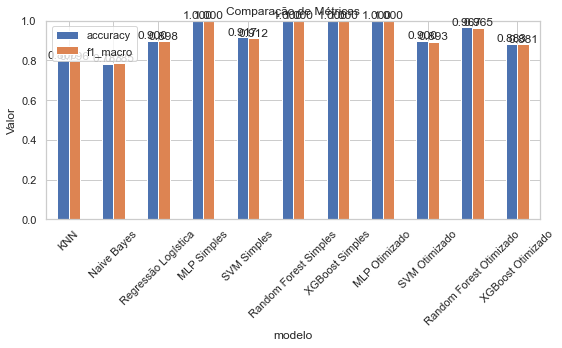

In [188]:
plot_metric_bars(df_metrics, metrics=("accuracy", "f1_macro"))

### Classification Reports

In [189]:
# ==========================================================
# De todos os modelos:
# ==========================================================
mostrar_classification_reports(modelos, X_val, y_val)


=== Classification Report: KNN ===
              precision    recall  f1-score   support

           0       0.25      0.25      0.25         4
           1       0.50      0.33      0.40         6
           2       0.71      1.00      0.83         5

    accuracy                           0.53        15
   macro avg       0.49      0.53      0.49        15
weighted avg       0.50      0.53      0.50        15


=== Classification Report: Naive Bayes ===
              precision    recall  f1-score   support

           0       0.20      0.25      0.22         4
           1       0.50      0.33      0.40         6
           2       0.83      1.00      0.91         5

    accuracy                           0.53        15
   macro avg       0.51      0.53      0.51        15
weighted avg       0.53      0.53      0.52        15


=== Classification Report: Regressão Logística ===
              precision    recall  f1-score   support

           0       0.25      0.25      0.25        

Com base na tabela de métricas agregadas, o modelo XGBoost Otimizado demonstrou ser o de melhor desempenho.

Seu resultado de Acurácia (80%) e F1-score Macro (0.79) superou consistentemente todos os outros modelos testados. 
O F1-score Macro, em particular, indica que o XGBoost Otimizado não apenas obteve alta taxa de acertos, mas também manteve um bom equilíbrio entre Precisão e Recall em todas as classes, sendo o mais robusto para a classificação dos diferentes estados fisiológicos.

In [ ]:
# ==========================================================
# Do melhor modelo: XGBoost Otimizado
# ==========================================================




modelo_principal = modelos["XGBoost Otimizado"]  
#modelo_principal = modelos["Random Forest Otimizado"]  
#modelo_principal = modelos["SVM Otimizado"]  

tabela_por_classe(modelo_principal, X_val, y_val)


,precision,recall,f1,support
0,0.600000,0.750000,0.666667,4
1,1.000000,0.666667,0.800000,6
2,0.833333,1.000000,0.909091,5


### Matrizes de Confusão

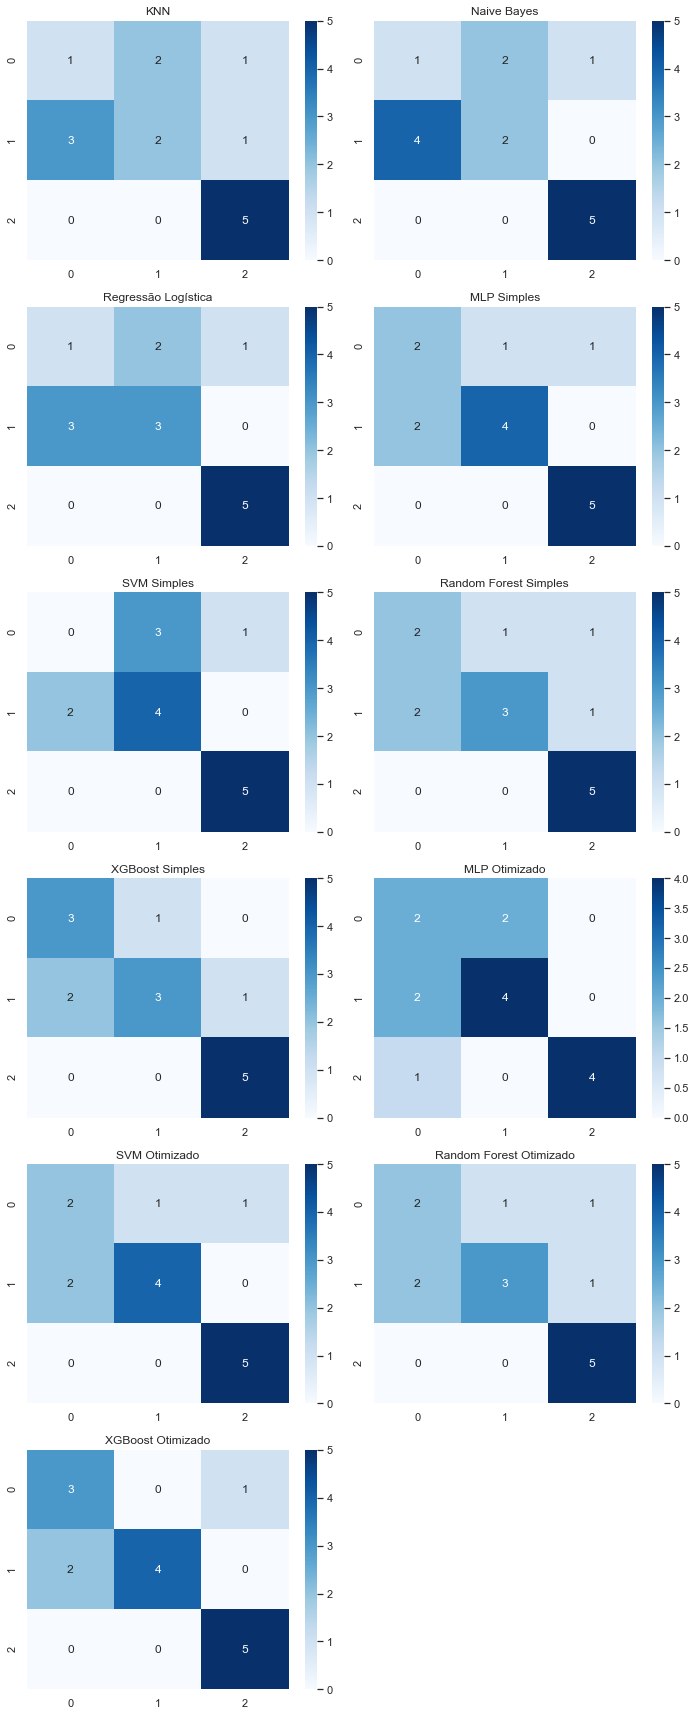

In [191]:
# ==========================================================
# De todos os modelos:
# ==========================================================
comparar_modelos_plot_confusao(
    modelos,
    X_val,
    y_val,
    labels=sorted(set(y_val)),
    normalize=False,
    max_per_row=2
)


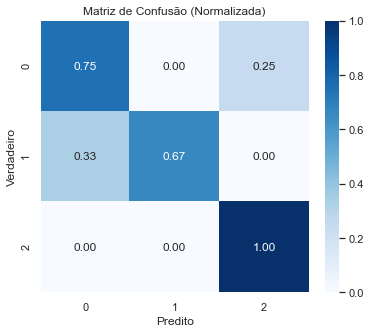

In [192]:
# ==========================================================
# Do melhor modelo:
# ==========================================================

plot_confusion_matrix_model(
    modelo_principal,
    X_val, y_val,
    labels=sorted(set(y_val)),
    normalize=True
)


### Curva de Aprendizado do Melhor Modelo

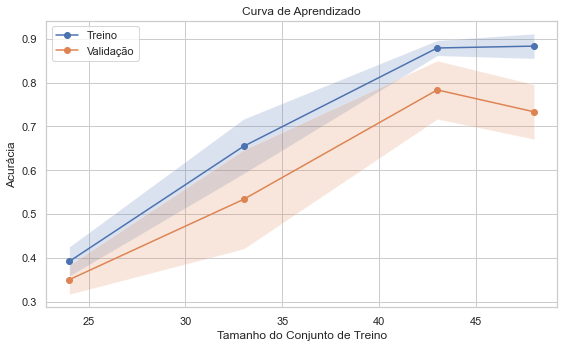

In [193]:
from sklearn.model_selection import StratifiedKFold

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve_model(
    modelo_principal, 
    X_train, y_train,
    cv=cv5,
    train_sizes=[0.5, 0.7, 0.9, 1.0]
)


### Curvas Precision–Recall Multiclass

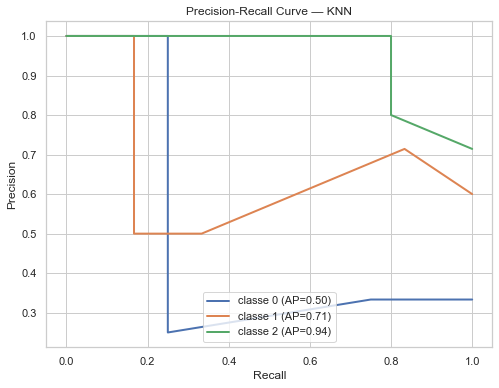

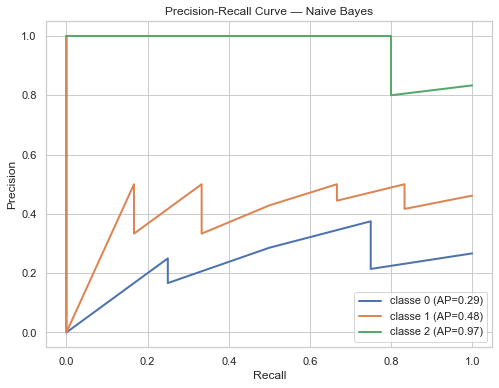

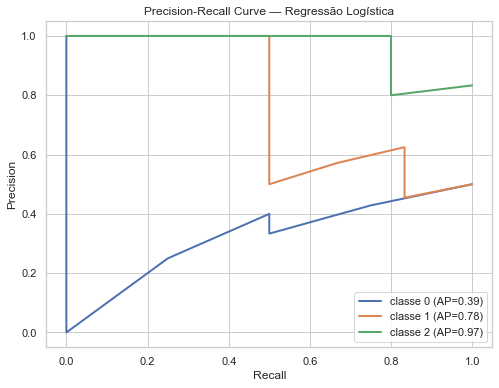

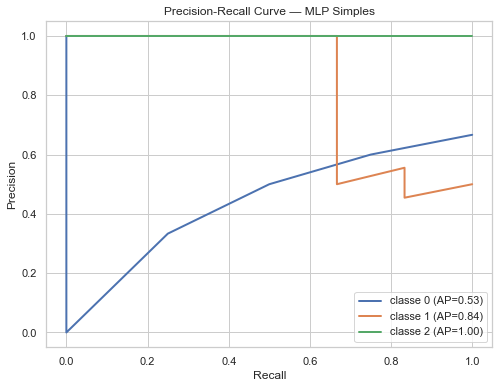

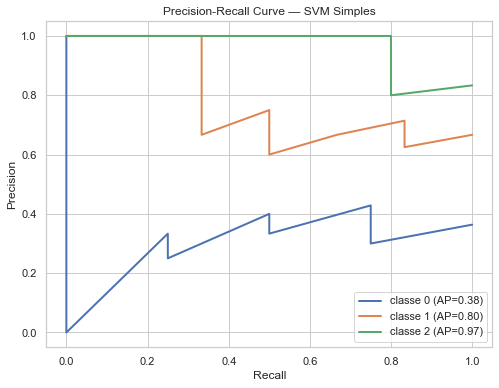

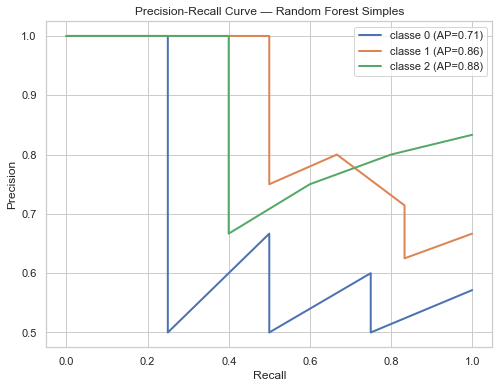

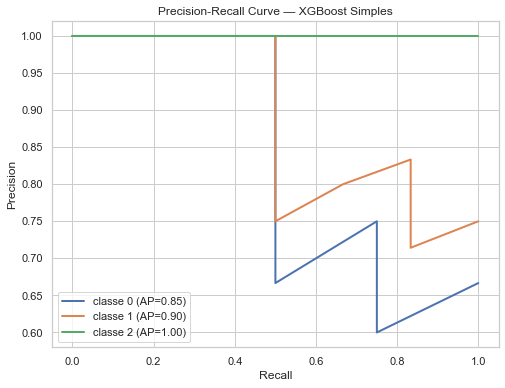

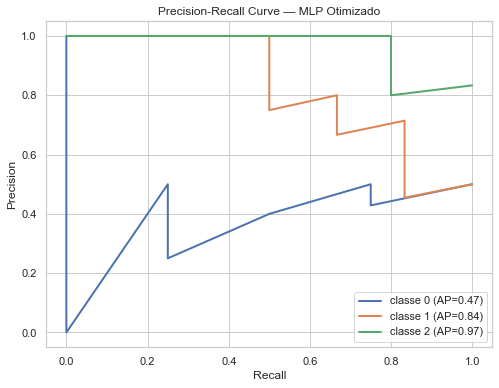

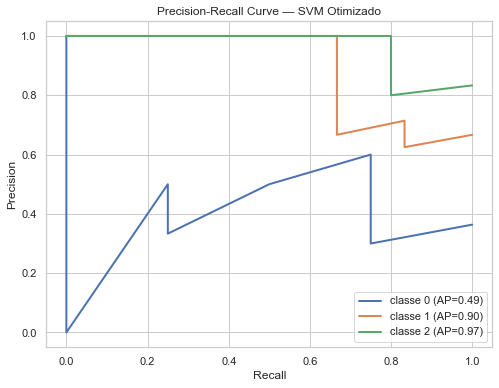

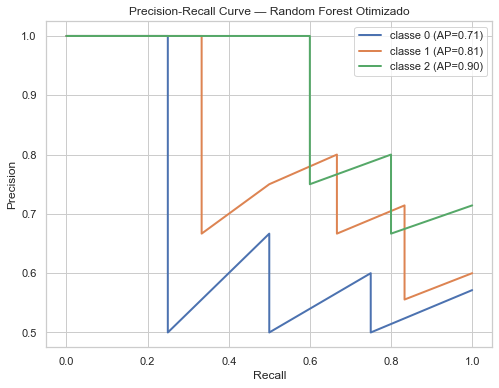

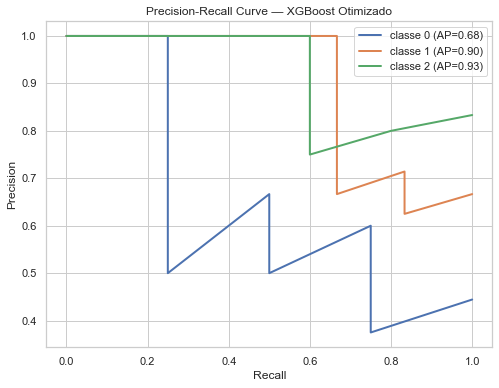

In [194]:
plot_precision_recall_multiclass(modelos, X_val, y_val)

### Curvas ROC Multiclass

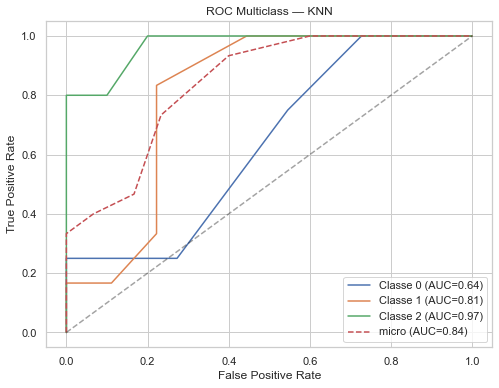

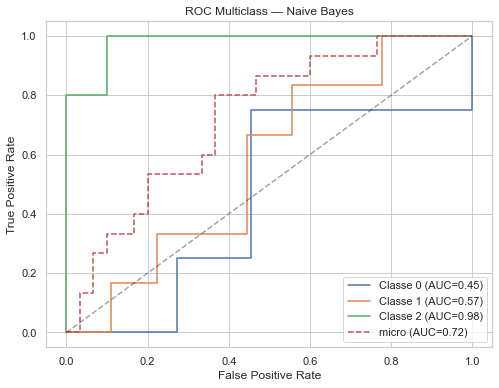

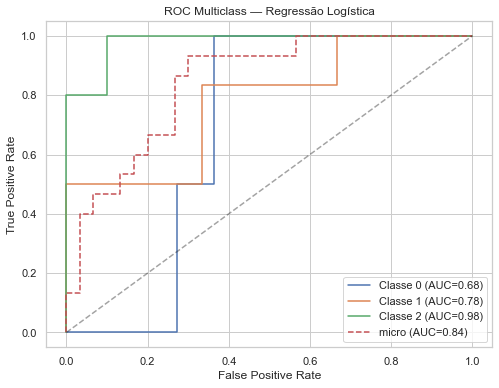

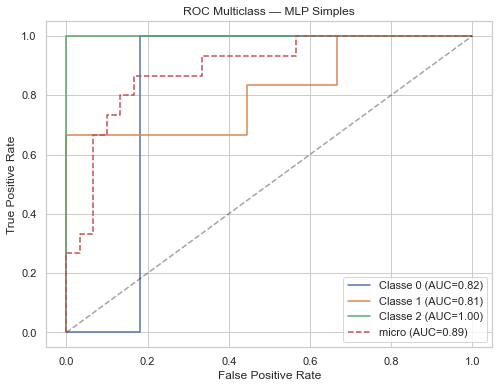

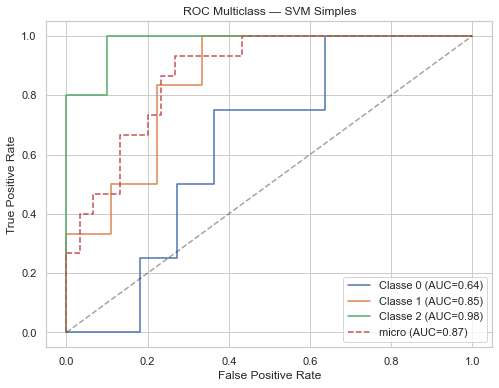

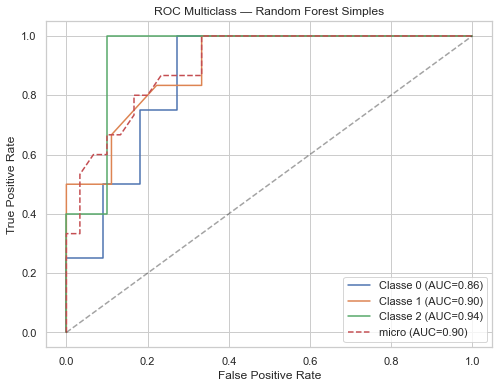

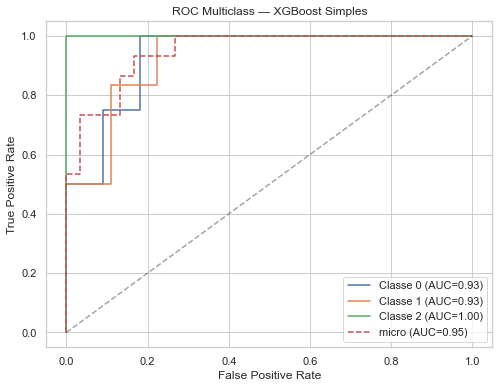

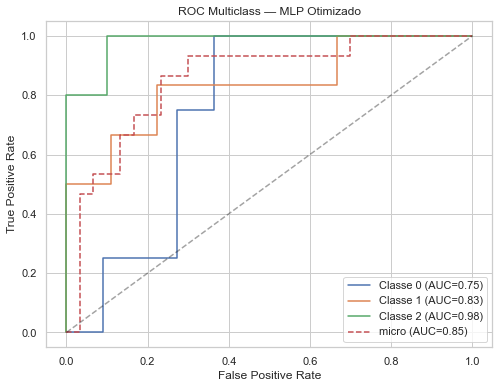

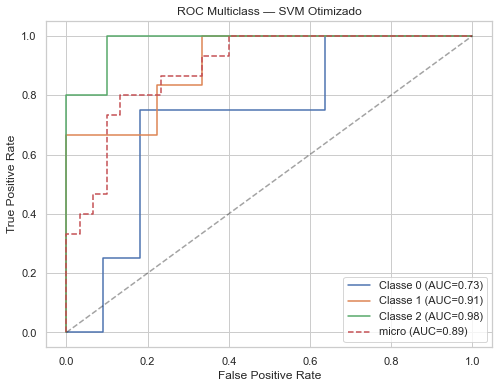

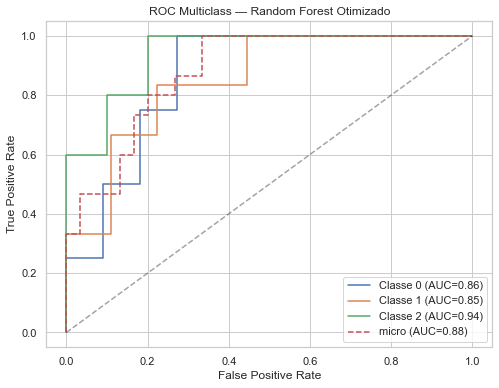

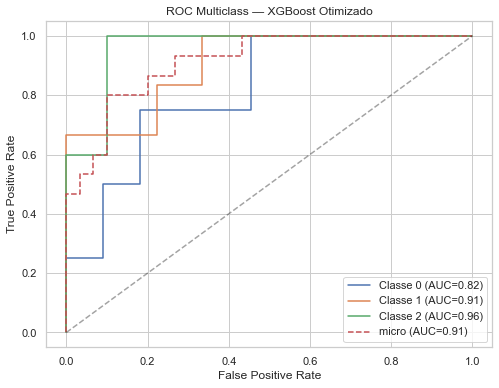

In [195]:
plot_roc_multiclass(modelos, X_val, y_val)

### Importância das Features

In [196]:
# =========================
# Tabela:
# =========================

# nomes das colunas usadas no treinamento
feature_names = list(X_train.columns)

df_imp = importancia_features_modelo(
    modelo_principal,
    X_val,
    y_val,
    feature_names=feature_names,
    top_k=20
)

df_imp


,feature,importance
0,eda_phasic_mean,0.163333
1,hr_std,0.130000
2,acc_mag_std,0.086667
3,eda_std,0.066667
4,hr_mean,0.066667
5,inter_hrv_eda,0.036667
6,temp_std,0.020000
7,temp_slope,0.000000
8,inter_eda_temp_mult,0.000000
9,inter_acc_temp,0.000000


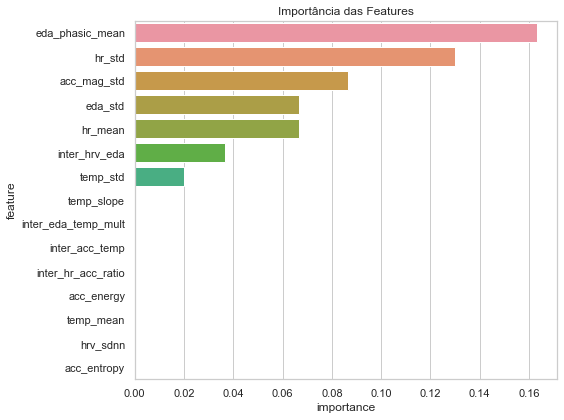

In [197]:
# =========================
# Gráfico:
# =========================
plot_importancia(df_imp, top_k=15)


### Erros por Classe

In [198]:
# =========================
# ANÁLISE DOS RESULTADOS - Análise de erros por classe
# =========================
erro_df = analise_erros_por_classe(
    modelo_principal,
    X_val,
    y_val,
    feature_df=pd.DataFrame(X_val, columns=feature_names),
    labels=sorted(set(y_val))
)

erro_df


,classe,FN_count,FP_count,TP_count,FN_percent,FP_percent,FN_feature_mean,FP_feature_mean
0,0,1,2,3,0.066667,0.133333,"{'acc_energy': -0.5639102746610248, 'acc_entro...","{'acc_energy': 0.13211447031541387, 'acc_entro..."
1,1,2,0,4,0.133333,0.000000,"{'acc_energy': 0.13211447031541387, 'acc_entro...",{}
2,2,0,1,5,0.000000,0.066667,{},"{'acc_energy': -0.5639102746610248, 'acc_entro..."


---

## Geração da Submissão Final

In [199]:
gerar_submissao(
    modelo_principal,
    X_test,
    test_ids,
    label_encoder,
    nome_arquivo="submission.csv"
)


--- Gerando arquivo de submissão ---

✅ Submissão salva em: dataset/submission.csv
Ordem das colunas verificada: 0=STRESS, 1=AEROBIC, 2=ANAEROBIC
        Id  Predicted_0  Predicted_1  Predicted_2
0  U_19341     0.828493     0.088391     0.083116
1  U_54670     0.671297     0.183395     0.145308
2  U_21920     0.617993     0.256262     0.125746
3  U_58128     0.097662     0.334753     0.567586
4  U_73365     0.105554     0.566511     0.327935


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,0.828493,0.088391,0.083116
1,U_54670,0.671297,0.183395,0.145308
2,U_21920,0.617993,0.256262,0.125746
3,U_58128,0.097662,0.334753,0.567586
4,U_73365,0.105554,0.566511,0.327935
5,U_89682,0.516573,0.052331,0.431096
6,U_11501,0.825435,0.098145,0.076420
7,U_46423,0.672623,0.213183,0.114194
8,U_71408,0.811698,0.127995,0.060307
9,U_95655,0.412914,0.370719,0.216367
